In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import plotly.graph_objects as go
import os
import sys  

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import tf_neuralnetwork as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
VOL = '/mnt/data1/stock/mlsoundings/results'

In [3]:
X = np.linspace(0, 5, 20)
T = np.sin(X)

In [4]:
from sklearn.isotonic import IsotonicRegression
# iso_reg = IsotonicRegression().fit(rap[0,:,-1], raob[0,:,1])
# iso_reg.predict(rap[0,:,1])

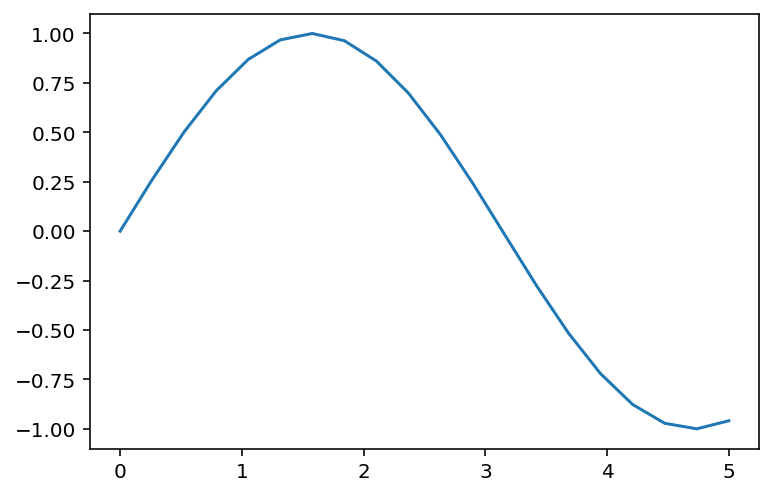

In [5]:
plt.plot(X, T)

## Baseline Metrics

In [6]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

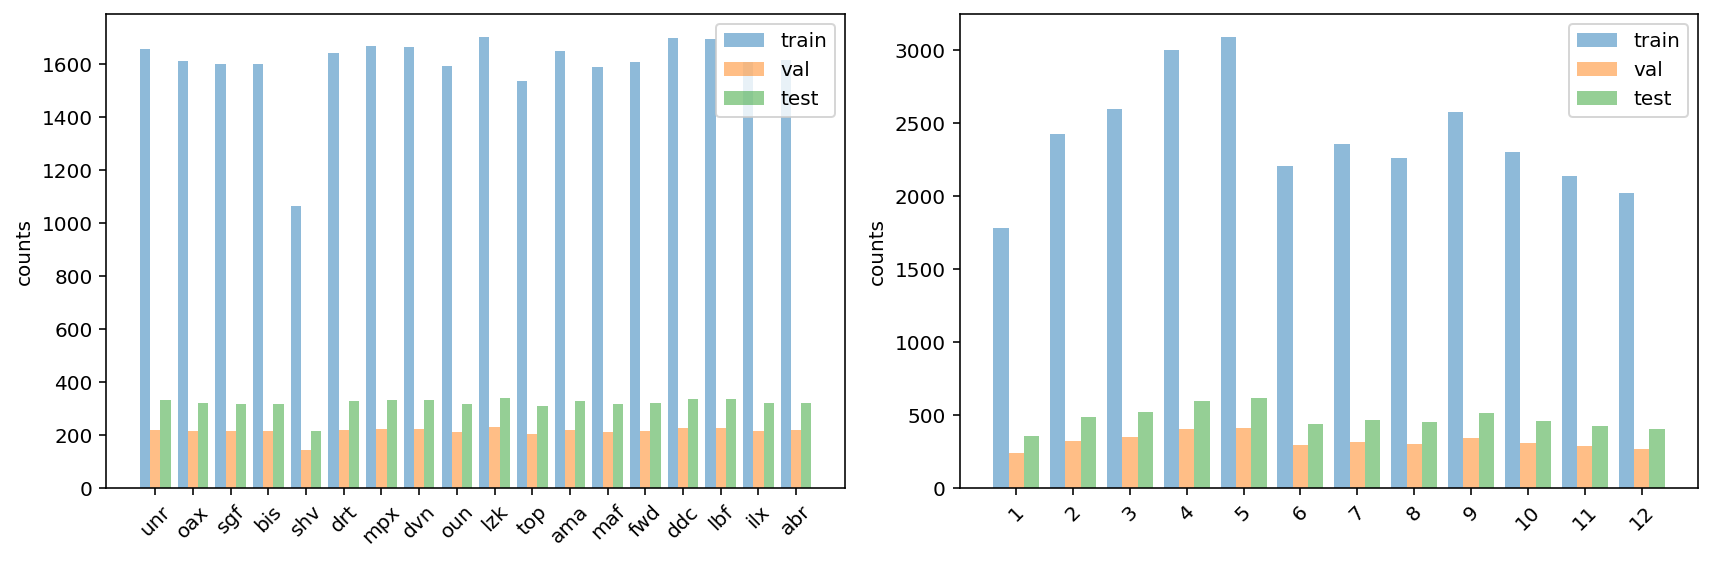

In [7]:
locations = {'bis', 'abr', 'unr', 'lbf', 'oax', 'top',
             'ddc', 'oun', 'ama', 'fwd', 'maf', 'drt',
             'lzk', 'sgf', 'shv', 'dvn', 'ilx', 'mpx'} # 'sgp'
l_ind = np.arange(len(locations))
months = np.arange(1, 13)

width = 0.27 # the width of the bars

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

FILEtrain_content = np.array([f.split('_') for f in FILEtrain])
FILEval_content   = np.array([f.split('_') for f in FILEval])
FILEtest_content  = np.array([f.split('_') for f in FILEtest])

_, counts = np.unique(FILEtrain_content[:,0], return_counts=True)
rects1 = axs[0].bar(l_ind, counts, width, alpha=0.5)
_, counts = np.unique(FILEval_content[:,0], return_counts=True)
rects2 = axs[0].bar(l_ind+width, counts, width, alpha=0.5)
_, counts = np.unique(FILEtest_content[:,0], return_counts=True)
rects3 = axs[0].bar(l_ind+width*2, counts, width, alpha=0.5)

axs[0].set_ylabel('counts')
axs[0].set_xticks(l_ind+width)
axs[0].set_xticklabels(locations, rotation=45)
axs[0].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

_, counts = np.unique(pd.to_datetime(FILEtrain_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects1 = axs[1].bar(months, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEval_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects2 = axs[1].bar(months+width, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEtest_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects3 = axs[1].bar(months+width*2, counts, width, alpha=0.5)

axs[1].set_ylabel('counts')
axs[1].set_xticks(months+width)
axs[1].set_xticklabels(months, rotation=45)
axs[1].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

fig.tight_layout()

In [8]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [9]:
def min_max(df):
    min_i = np.inf
    min_v = np.inf
    max_i = 0
    max_v = 0
    for i, row in df.iterrows():
        train_rmse = np.asarray(literal_eval(row[f'root_mean_squared_error']))
        if train_rmse.min() < min_v:
            min_v = train_rmse.min()
            min_i = i
        if train_rmse.max() > max_v:
            max_v = train_rmse.max()
            max_i = i  

        plt.plot(train_rmse)
        plt.plot(np.asarray(literal_eval(row[f'val_root_mean_squared_error'])),'--')

    return min_i, min_v, max_i, max_v

(38373, 256)


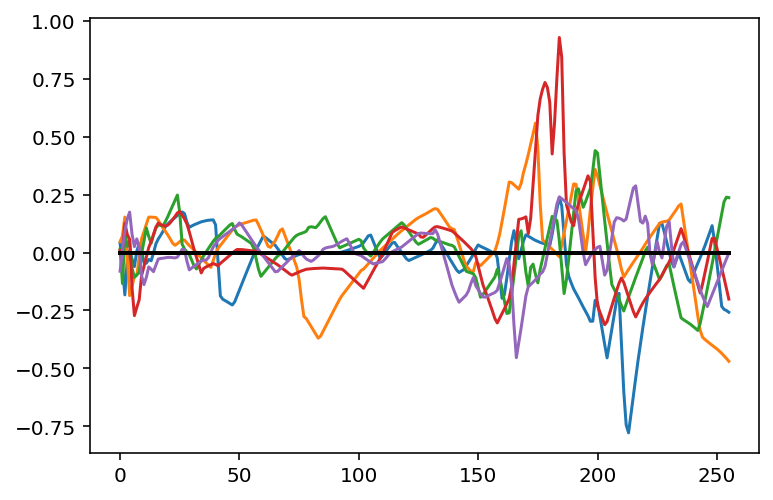

In [10]:
import copy

def _standardizeX(X):
    result = (X - Xmeans) / XstdsFixed
    result[:, Xconstant] = 0.0
    return result

def _unstandardizeX(Xs):
    return Xstds * Xs + Xmeans

def _standardizeT(T):
    result = (T - Tmeans) / TstdsFixed
    result[:, Tconstant] = 0.0
    return result

def _unstandardizeT(Ts):
    return Tstds * Ts + Tmeans

X = rap
T = raob

Xmeans = X.mean(axis=0)
Xstds = X.std(axis=0)
Xconstant = Xstds == 0
XstdsFixed = copy.copy(Xstds)
XstdsFixed[Xconstant] = 1

Tmeans = T.mean(axis=0)
Tstds = T.std(axis=0)
Tconstant = Tstds == 0
TstdsFixed = copy.copy(Tstds)
TstdsFixed[Tconstant] = 1

X = _standardizeX(X)
T = _standardizeT(T)

diff = X[:,:,dl.TEMPERATURE] - T[:,:,dl.TEMPERATURE]
print(diff.shape)
fig, axs = plt.subplots(figsize=(6, 4))
for p in (diff[:5]):
    axs.plot(p)
    
axs.plot(diff.mean(axis=0), color='black', lw=2);

(38373, 256)


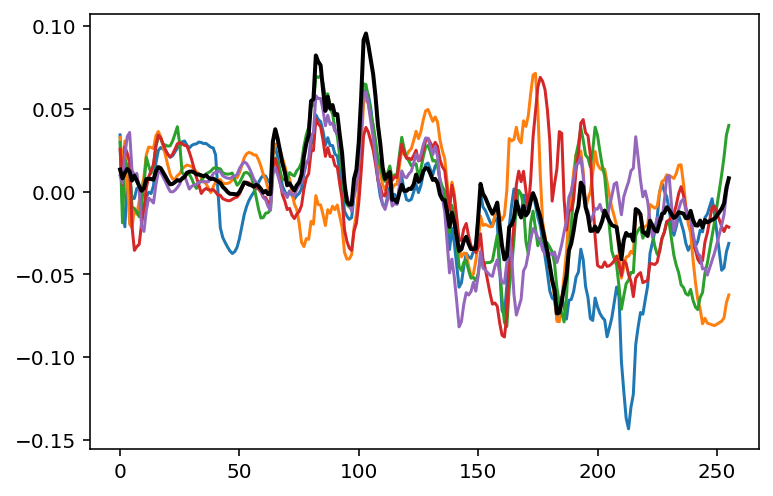

In [11]:
import copy

def _standardizeX(X):
    result = (X - Xmin) / (Xmax - Xmin)
    return result

def _unstandardizeX(Xs):
    return  Xs * (Xmax - Xmin) + Xmin

def _standardizeT(T):
    result = (T - Tmin) / (Tmax - Tmin)
    return result

def _unstandardizeT(Ts):
    return  Ts * (Tmax - Tmin) + Tmin

X = rap
T = raob

Xmin = X.min(axis=0)
Xmax = X.max(axis=0)

Tmin = T.min(axis=0)
Tmax = T.max(axis=0)

X = _standardizeX(X)
T = _standardizeT(T)

diff = X[:,:,dl.TEMPERATURE] - T[:,:,dl.TEMPERATURE]
print(diff.shape)
fig, axs = plt.subplots(figsize=(6, 4))
for p in (diff[:5]):
    axs.plot(p)
    
axs.plot(diff.mean(axis=0), color='black', lw=2);

# Linear

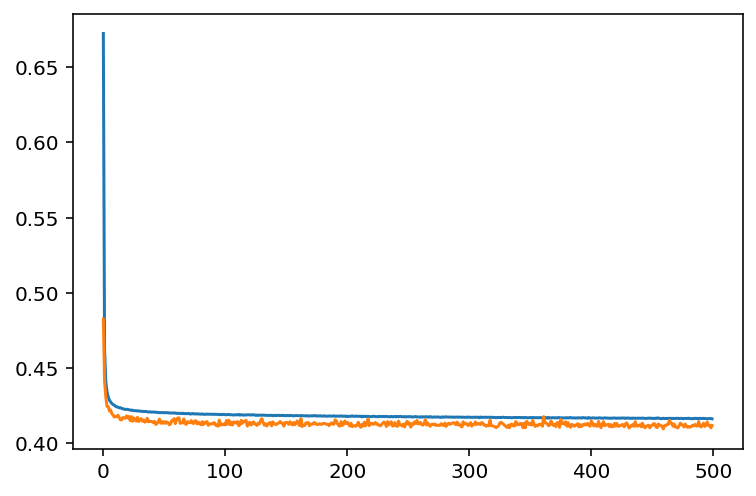

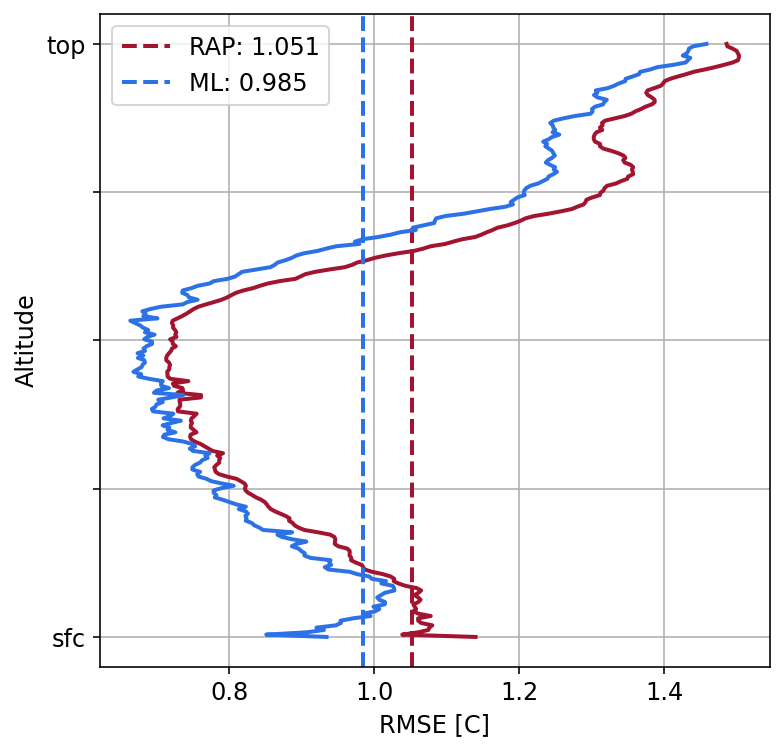

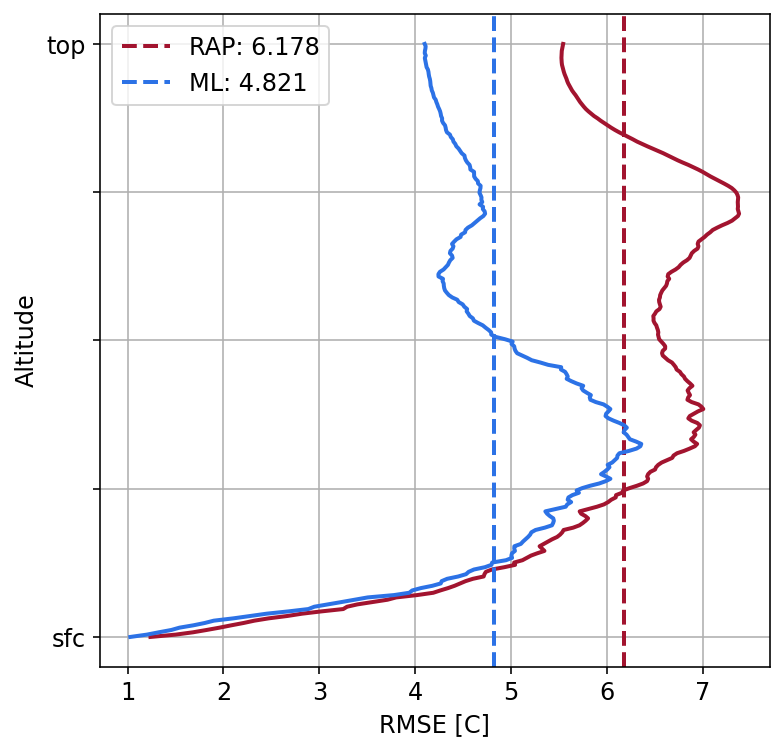

In [12]:
df = pd.read_csv(os.path.join(VOL, 'alley_linear_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [13]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_network_inputs,hiddens,n_network_outputs,optim,lr,activ,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
13,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[0],512,adam,0.0001,None,MAE,500,128,False,False,"[0.4674375355243683, 0.30134356021881104, 0.27...","[0.6723198294639587, 0.4626310467720032, 0.441...","[0.45201393961906433, 0.2140275239944458, 0.19...","[0.4674375355243683, 0.30134356021881104, 0.27...","[0.3280690610408783, 0.28186851739883423, 0.26...","[0.48244524002075195, 0.44130873680114746, 0.4...","[0.23275341093540192, 0.19475339353084564, 0.1...","[0.3280690610408783, 0.28186851739883423, 0.26...","[0.9462844939249322, 0.8789580484671055, 0.935...",0.997444,"[0.9462844939249322, 0.8789580484671055, 0.935...",0.992267,"[1.14516902774704, 1.2712054428803228, 1.35168...",4.861246,"[1.14516902774704, 1.2712054428803228, 1.35168...",3.025237,"[1.0290888908070828, 0.8838952158130664, 0.926...",0.998081,"[1.0290888908070828, 0.8838952158130664, 0.926...",0.999686,"[1.2934094952753439, 1.2307329326563, 1.361772...",4.850655,"[1.2934094952753439, 1.2307329326563, 1.361772...",2.983203,"[0.9341198518291088, 0.851037950348622, 0.9067...",0.984715,"[0.9341198518291088, 0.851037950348622, 0.9067...",0.981992,"[1.0285353183810146, 1.2009416859347117, 1.325...",4.821307,"[1.0285353183810146, 1.2009416859347117, 1.325...",2.951306
8,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[0],512,adam,0.0001,None,MSE,500,128,False,False,"[0.5004053711891174, 0.2443869709968567, 0.214...","[0.7073934078216553, 0.49435511231422424, 0.46...","[0.5004053711891174, 0.2443869709968567, 0.214...","[0.5036265850067139, 0.3388965129852295, 0.304...","[0.2710314691066742, 0.2179899662733078, 0.201...","[0.5206068158149719, 0.4668939709663391, 0.448...","[0.2710314691066742, 0.2179899662733078, 0.201...","[0.3693199157714844, 0.3151859939098358, 0.293...","[1.0580963337428062, 0.9318384499942015, 0.987...",0.997933,"[1.0580963337428062, 0.9318384499942015, 0.987...",1.003692,"[1.1429870849064376, 1.2638540975327814, 1.341...",4.965855,"[1.1429870849064376, 1.2638540975327814, 1.341...",2.980223,"[1.0940727802779247, 0.9295407160920474, 0.972...",0.998797,"[1.0940727802779247, 0.9295407160920474, 0.972...",1.005786,"[1.2712960815041143, 1.2212246321709643, 1.349...",4.933483,"[1.2712960815041143, 1.2212246321709643, 1.349...",2.939229,"[1.0672420064641845, 0.9123087223726988, 0.960...",0.984948,"[1.0672420064641845, 0.9123087223726988, 0.960...",0.995601,"[1.0458612291116516, 1.2058548823352573, 1.323...",4.926240,"[1.0458612291116516, 1.2058548823352573, 1.323...",2.921940
12,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[0],512,adam,0.0001,None,MSE,500,128,False,False,"[0.4832763671875, 0.23398099839687347, 0.20519...","[0.6951808333396912, 0.48371583223342896, 0.45...","[0.4832763671875, 0.23398099839687347, 0.20519...","[0.49387603998184204, 0.33331120014190674, 0.3...","[0.2579246461391449, 0.20904459059238434, 0.19...","[0.5078628063201904, 0.4572139382362366, 0.438...","[0.2579246461391449, 0.20904459059238434, 0.19...","[0.36

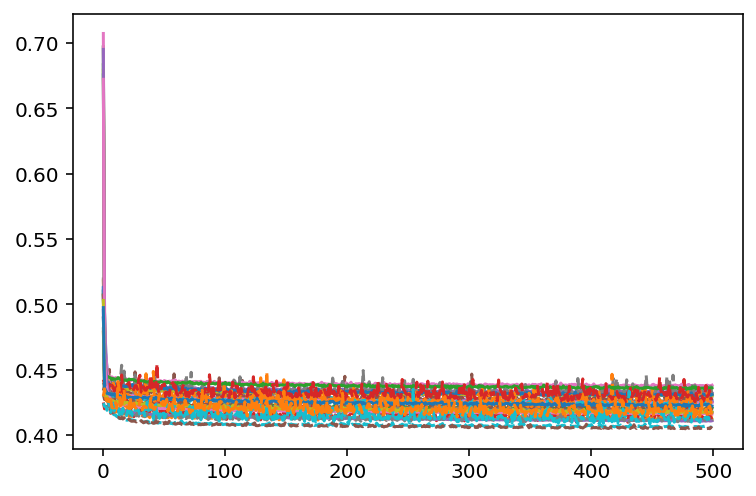

In [14]:
min_i, min_v, max_i, max_v = min_max(df)

# Fully Connected

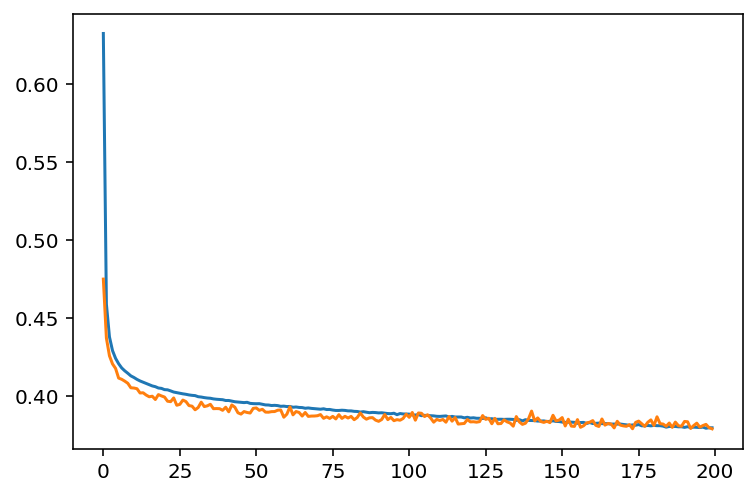

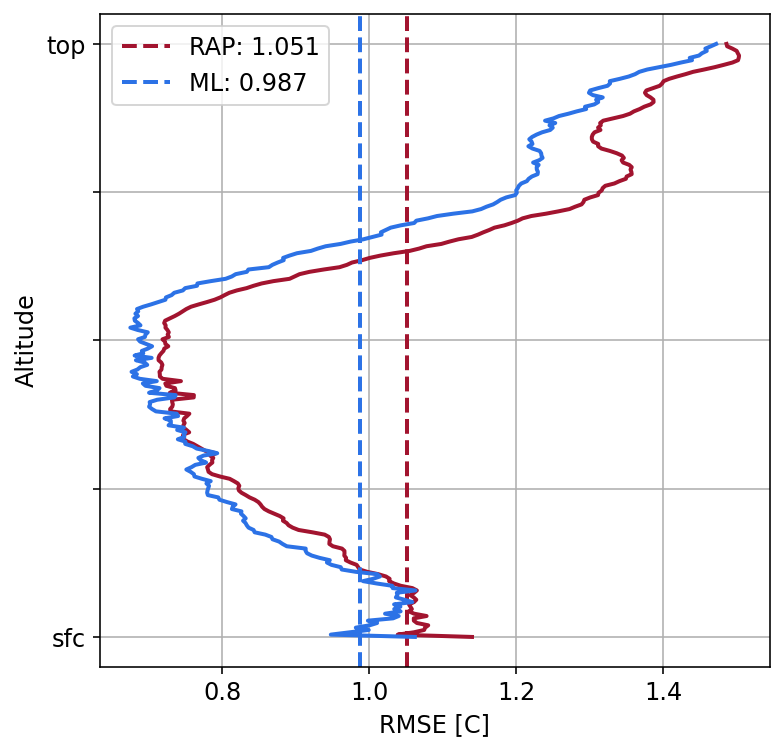

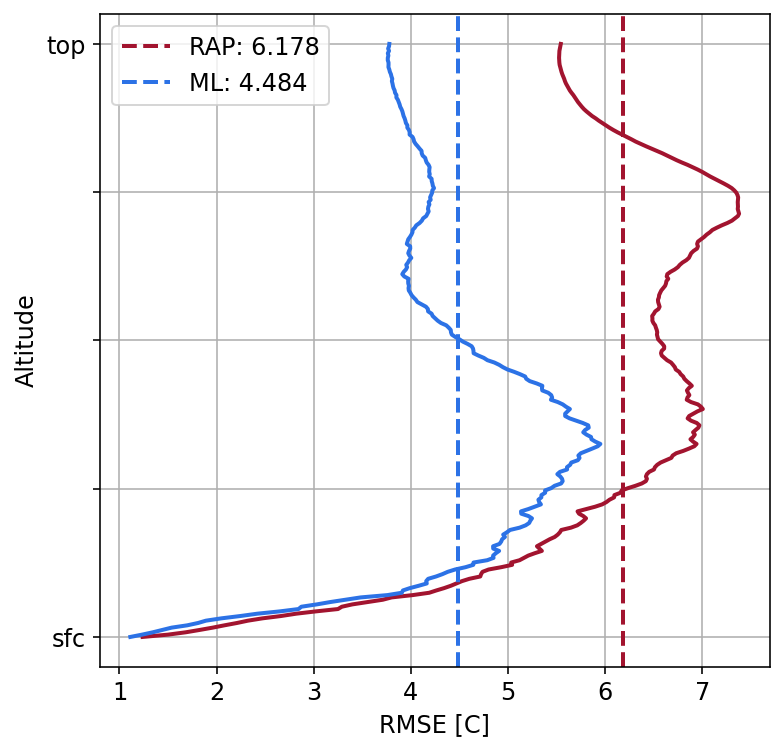

In [15]:
df = pd.read_csv(os.path.join(VOL, 'alley_fully_connected_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [16]:
df.sort_values(['ml_temperature_test_mean_rmse_sfc'])[:5]

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_network_inputs,hiddens,n_network_outputs,optim,lr,activ,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
462,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[512],512,adam,0.0001,relu,MAE,200,128,False,False,"[0.44129911065101624, 0.3015071749687195, 0.27...","[0.632550835609436, 0.45896220207214355, 0.437...","[0.4001205563545227, 0.21064627170562744, 0.19...","[0.44129911065101624, 0.3015071749687195, 0.27...","[0.3227476477622986, 0.2848619222640991, 0.270...","[0.4749784767627716, 0.4371693432331085, 0.425...","[0.2256045639514923, 0.1911170333623886, 0.181...","[0.3227476477622986, 0.2848619222640991, 0.270...","[1.0431375180904943, 0.9602255880733224, 0.987...",0.983368,"[1.0431375180904943, 0.9602255880733224, 0.987...",1.018457,"[1.1993667645768218, 1.2607652367605624, 1.321...",4.427033,"[1.1993667645768218, 1.2607652367605624, 1.321...",2.935470,"[1.1159481399574263, 0.9698248966507466, 0.993...",0.998718,"[1.1159481399574263, 0.9698248966507466, 0.993...",1.043068,"[1.3465250887679, 1.238035452463609, 1.3526620...",4.498283,"[1.3465250887679, 1.238035452463609, 1.3526620...",2.940988,"[1.0618686096326357, 0.9475138021893038, 0.973...",0.987303,"[1.0618686096326357, 0.9475138021893038, 0.973...",1.022900,"[1.1120361929781033, 1.232982487763224, 1.3437...",4.483649,"[1.1120361929781033, 1.232982487763224, 1.3437...",2.908464
342,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[512],512,adam,0.0001,relu,MAE,200,128,False,False,"[0.4453878700733185, 0.3044635057449341, 0.282...","[0.6398202180862427, 0.4664234519004822, 0.446...","[0.40936994552612305, 0.2175508290529251, 0.19...","[0.4453878700733185, 0.3044635057449341, 0.282...","[0.32458293437957764, 0.28809553384780884, 0.2...","[0.4810807704925537, 0.4469957947731018, 0.435...","[0.23143869638442993, 0.19980525970458984, 0.1...","[0.32458293437957764, 0.28809553384780884, 0.2...","[1.035665483735084, 0.9620753300089661, 0.9898...",0.991618,"[1.035665483735084, 0.9620753300089661, 0.9898...",1.023465,"[1.2068738339408884, 1.2606830284628097, 1.325...",4.757345,"[1.2068738339408884, 1.2606830284628097, 1.325...",2.939909,"[1.110434510234478, 0.9657228757715596, 0.9935...",1.003743,"[1.110434510234478, 0.9657228757715596, 0.9935...",1.038066,"[1.361700994304972, 1.2536880931341137, 1.3591...",4.780009,"[1.361700994304972, 1.2536880931341137, 1.3591...",2.938342,"[1.0509376712600702, 0.9457085089357298, 0.974...",0.992650,"[1.0509376712600702, 0.9457085089357298, 0.974...",1.024886,"[1.1179553746061957, 1.2277015089949244, 1.342...",4.771514,"[1.1179553746061957, 1.2277015089949244, 1.342...",2.916543
338,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[512],512,adam,0.0001,tanh,MAE,200,128,False,False,"[0.40947917103767395, 0.2857065796852112, 0.27...","[0.5937612652778625, 0.4533677399158478, 0.442...","[0.3525524437427521, 0.20554231107234955, 0.19...","[0.40947917103767395, 0.2857065796852112, 0.27...","[0.3012349307537079, 0.2738107144832611, 0.266...","[0.460895836353302, 0.4394075572490692, 0.4329...","[0.21242497861385345, 0.19307899475097656, 0.1...","[0.3012349307537079

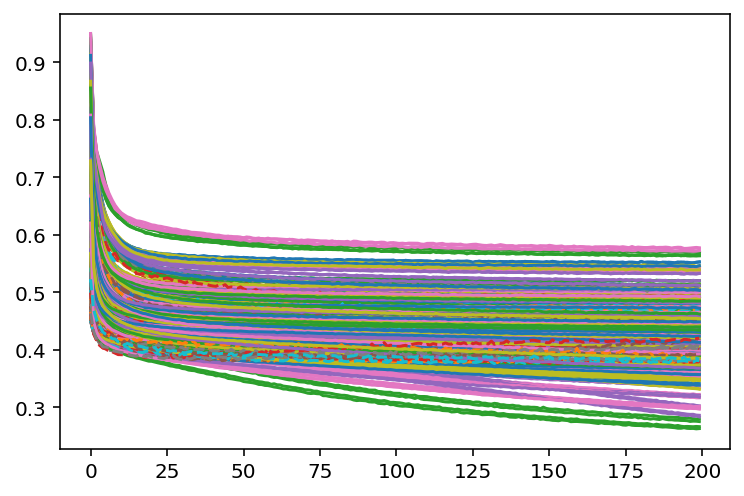

In [17]:
min_i, min_v, max_i, max_v = min_max(df)

# Convolutional

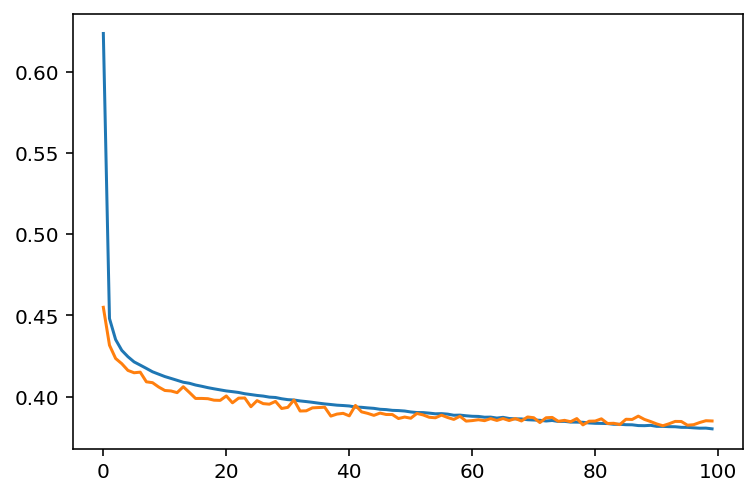

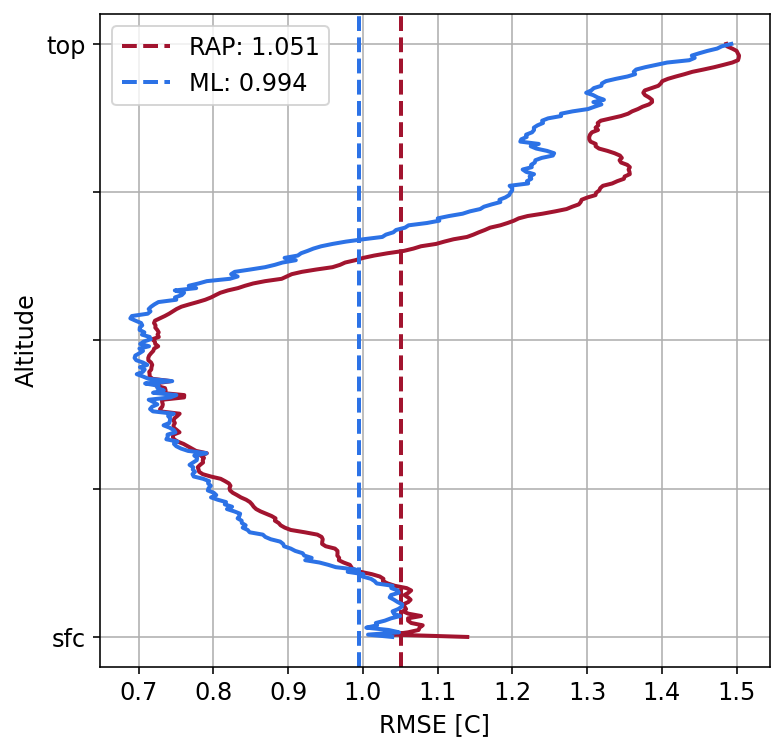

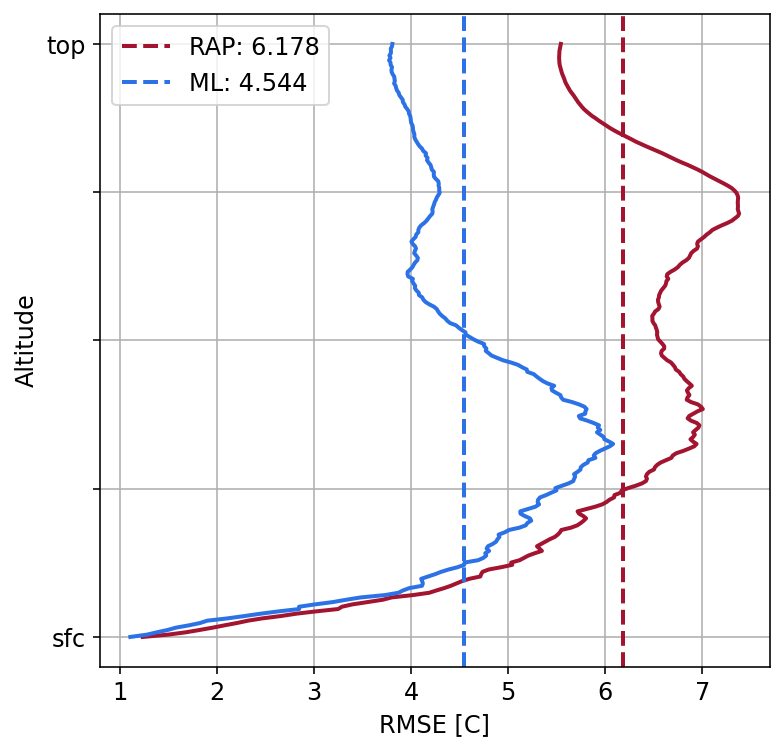

In [18]:
df = pd.read_csv(os.path.join(VOL, 'alley_multi_cnn_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [19]:
sorted_df = df.sort_values(['ml_temperature_test_mean_rmse'])
sorted_df.head()

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
140,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.43397727608680725, 0.2865692973136902, 0.27...","[0.6234780550003052, 0.4481193721294403, 0.435...","[0.3887248933315277, 0.2008109837770462, 0.189...","[0.43397727608680725, 0.2865692973136902, 0.27...","[0.2993396818637848, 0.2748476564884186, 0.264...","[0.4550319314002991, 0.43171408772468567, 0.42...","[0.20705406367778778, 0.18637704849243164, 0.1...","[0.2993396818637848, 0.2748476564884186, 0.264...","[1.0514672976000132, 1.035913039368955, 1.0664...",0.991422,"[1.0514672976000132, 1.035913039368955, 1.0664...",1.034664,"[1.2329323303726492, 1.330324589189805, 1.3779...",4.513114,"[1.2329323303726492, 1.330324589189805, 1.3779...",2.956667,"[1.1836156939468943, 1.051455392387798, 1.0695...",1.008897,"[1.1836156939468943, 1.051455392387798, 1.0695...",1.061243,"[1.4046920741294933, 1.3282062976235238, 1.413...",4.573830,"[1.4046920741294933, 1.3282062976235238, 1.413...",2.936374,"[1.0392814154106833, 1.0069428943869878, 1.048...",0.994321,"[1.0392814154106833, 1.0069428943869878, 1.048...",1.035651,"[1.1105551119753951, 1.2830488375340978, 1.383...",4.543547,"[1.1105551119753951, 1.2830488375340978, 1.383...",2.910644
68,"[0, 1, 2, 3]","[1, 2]",[],"[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 8)",[],512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.4317910373210907, 0.2859981060028076, 0.271...","[0.6212928891181946, 0.4482140839099884, 0.435...","[0.38600483536720276, 0.20089586079120636, 0.1...","[0.4317910373210907, 0.2859981060028076, 0.271...","[0.3000187277793884, 0.27488934993743896, 0.26...","[0.4550275504589081, 0.43325796723365784, 0.42...","[0.20705009996891022, 0.18771246075630188, 0.1...","[0.3000187277793884, 0.27488934993743896, 0.26...","[1.33546208319405, 1.018218269656969, 1.030504...",0.992482,"[1.33546208319405, 1.018218269656969, 1.030504...",1.046574,"[1.4517835758749613, 1.4219747860725285, 1.405...",4.550553,"[1.4517835758749613, 1.4219747860725285, 1.405...",2.993145,"[1.3493579630184476, 1.0076509439075951, 1.019...",1.006821,"[1.3493579630184476, 1.0076509439075951, 1.019...",1.063441,"[1.5770034577808332, 1.3893762436374055, 1.427...",4.601253,"[1.5770034577808332, 1.3893762436374055, 1.427...",2.977188,"[1.3597897277021176, 1.029049827240289, 1.0165...",0.994912,"[1.3597897277021176, 1.029049827240289, 1.0165...",1.052523,"[1.3985114386604447, 1.394099430320027, 1.4243...",4.575268,"[1.3985114386604447, 1.394099430320027, 1.4243...",2.951274
104,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],"(256, 4)","(3, 3, 3)",[],512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.43298375606536865, 0.28815019130706787, 0.2...","[0.6233439445495605, 0.4541773200035095, 0.441...","[0.388557672500610

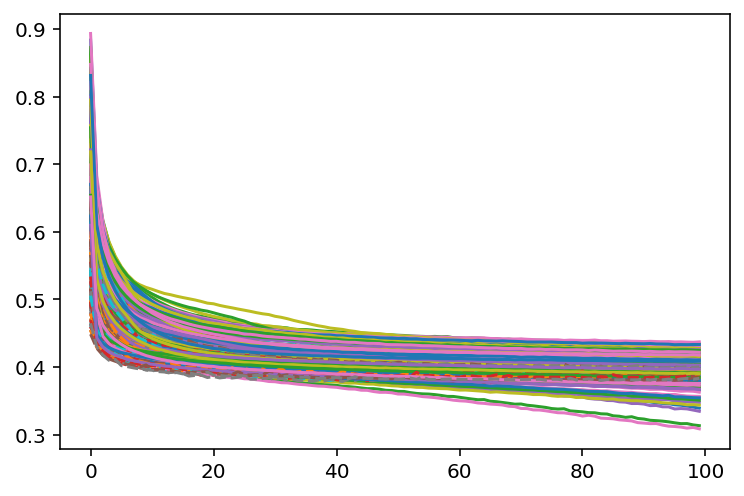

In [20]:
min_i, min_v, max_i, max_v = min_max(df)

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
118,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[512, 256]",512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MSE,100,128,False,False,"[0.4372572600841522, 0.21649466454982758, 0.19...","[0.6612542867660522, 0.4652898609638214, 0.441...","[0.4372572600841522, 0.21649466454982758, 0.19...","[0.4822936952114105, 0.3200552761554718, 0.297...","[0.23196110129356384, 0.20042243599891663, 0.1...","[0.48162341117858887, 0.4476856589317322, 0.42...","[0.23196110129356384, 0.20042243599891663, 0.1...","[0.341557115316391, 0.3063412010669708, 0.2891...","[1.2626653645458357, 1.1807850229761765, 1.277...",1.036566,"[1.2626653645458357, 1.1807850229761765, 1.277...",1.211785,"[1.3781639100190344, 1.4633529210438692, 1.520...",3.935008,"[1.3781639100190344, 1.4633529210438692, 1.520...",2.915663,"[1.3247314508501096, 1.2054663550852613, 1.288...",1.066948,"[1.3247314508501096, 1.2054663550852613, 1.288...",1.243259,"[1.5194914258453531, 1.4646036096572668, 1.573...",4.566695,"[1.5194914258453531, 1.4646036096572668, 1.573...",2.960155,"[1.293650075124406, 1.19681494683681, 1.287602...",1.055483,"[1.293650075124406, 1.19681494683681, 1.287602...",1.227898,"[1.310506734135407, 1.4491108772006462, 1.5512...",4.586619,"[1.310506734135407, 1.4491108772006462, 1.5512...",2.940289
119,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[512, 256]",512,"[32, 64, 128, 256, 256]","(3, 1)",relu,relu,adam,0.0001,MSE,100,128,False,True,"[0.574141263961792, 0.3252117931842804, 0.2777...","[0.7577211260795593, 0.5702734589576721, 0.526...","[0.574141263961792, 0.3252117931842804, 0.2777...","[0.5780319571495056, 0.4239158034324646, 0.385...","[0.2982834279537201, 0.23243917524814606, 0.21...","[0.5461533069610596, 0.48211947083473206, 0.46...","[0.2982834279537201, 0.23243917524814606, 0.21...","[0.4044734239578247, 0.3420489728450775, 0.323...","[2.7460640232685796, 2.179025999214226, 1.9929...",1.209267,"[2.7460640232685796, 2.179025999214226, 1.9929...",1.680039,"[2.0917004601178704, 2.0614875674343205, 2.062...",4.105163,"[2.0917004601178704, 2.0614875674343205, 2.062...",3.172872,"[2.7734489045611705, 2.2161783204083343, 2.057...",1.259486,"[2.7734489045611705, 2.2161783204083343, 2.057...",1.741482,"[2.210504977000764, 2.091551813186076, 2.13479...",4.631152,"[2.210504977000764, 2.091551813186076, 2.13479...",3.255425,"[2.7800238964717168, 2.202009894302957, 2.0129...",1.241814,"[2.7800238964717168, 2.202009894302957, 2.0129...",1.694632,"[2.0646685340558446, 2.075815510688698, 2.1076...",4.651297,"[2.0646685340558446, 2.075815510688698, 2.1076...",3.260827


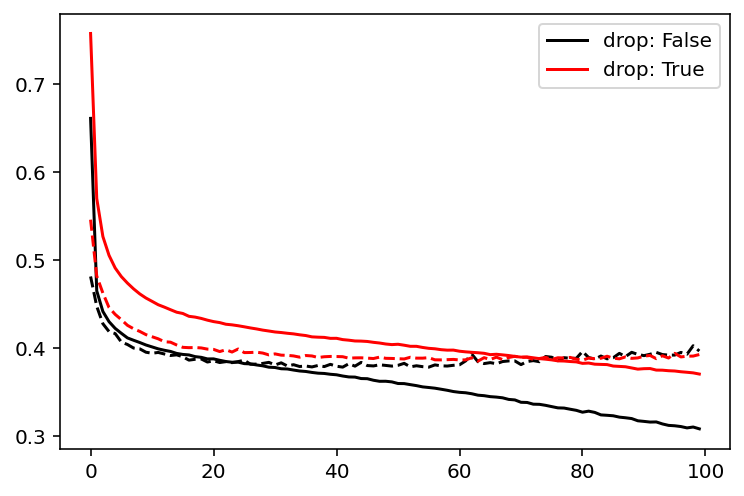

In [21]:
# get same models following first 16 params
filtered_df = df
for k, v in zip(df.iloc[min_i][:17].keys(), df.iloc[min_i][:17].values):
    filtered_df = filtered_df[filtered_df[k] == v]
    
#######

plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'root_mean_squared_error'])), color='k',
         label=f"drop: {filtered_df.iloc[0]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'val_root_mean_squared_error'])), '--k')

plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'root_mean_squared_error'])), color='r',
         label=f"drop: {filtered_df.iloc[1]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'val_root_mean_squared_error'])), '--r')

plt.legend()
filtered_df

# UNet

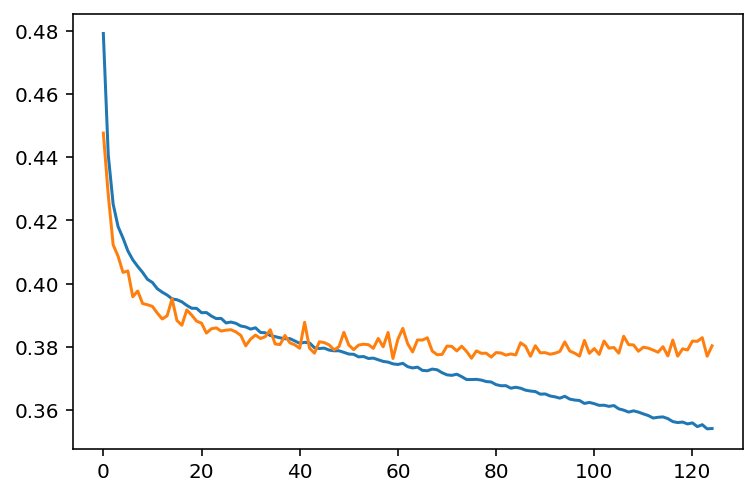

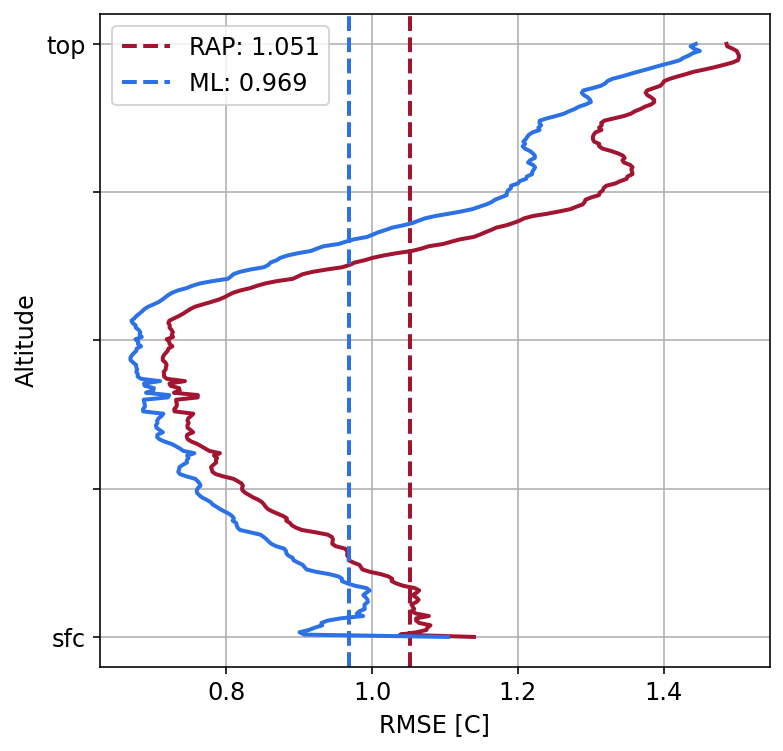

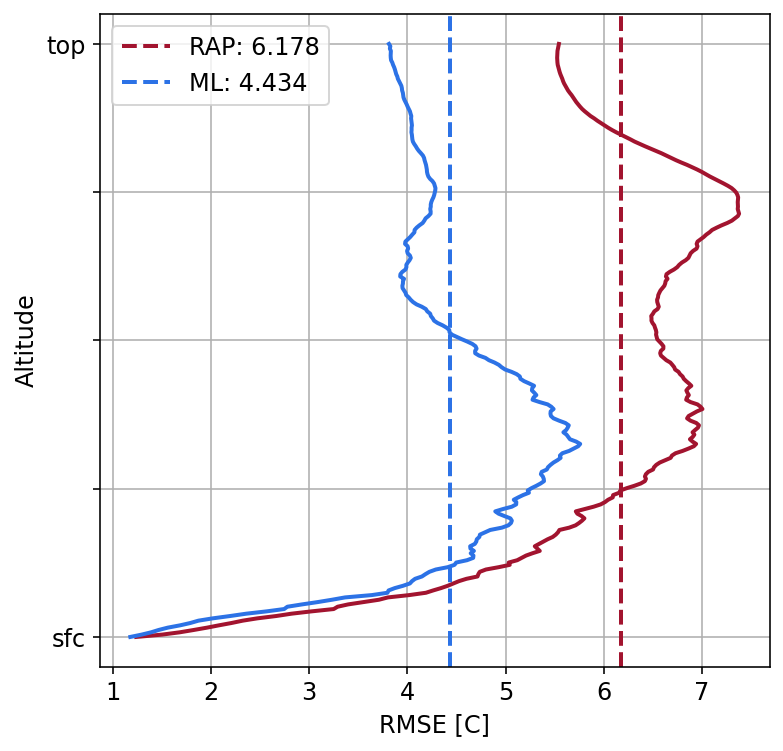

In [22]:
df = pd.read_csv(os.path.join(VOL, 'alley_skip_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
fig, ax = plt.subplots()
data_set = 'test' # 'train'
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_{data_set}_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

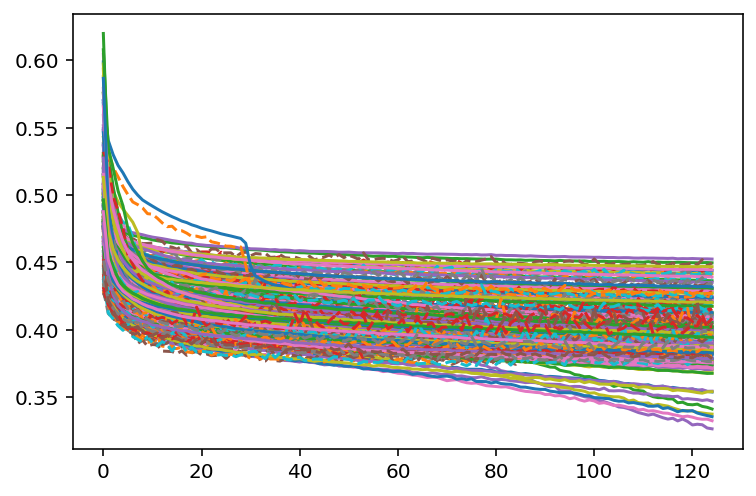

In [23]:
min_i, min_v, max_i, max_v = min_max(df)

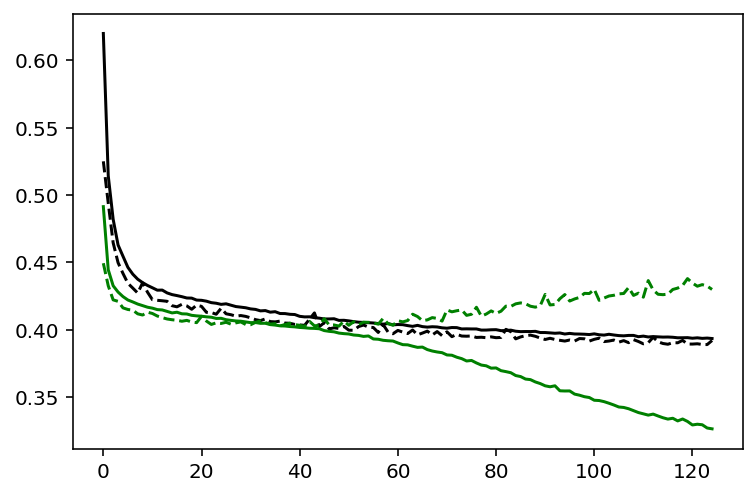

In [24]:
i = max_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'k')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--k')

i = min_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'g')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--g')

In [25]:
df.iloc[min_i] 

rap_input_dims                                                             [0, 1, 2, 3]
rap_output_dims                                                                  [1, 2]
rtma_input_channels                                                                  []
goes_input_channels                                                                  []
n_rap_inputs                                                                   (256, 4)
n_im_inputs                                                                         NaN
hiddens                                                                              []
n_network_outputs                                                                   512
n_units_in_conv_layers                                               [32, 64, 128, 256]
kernels_size_and_stride                                                          (3, 1)
rap_activation                                                                     relu
dense_activation                

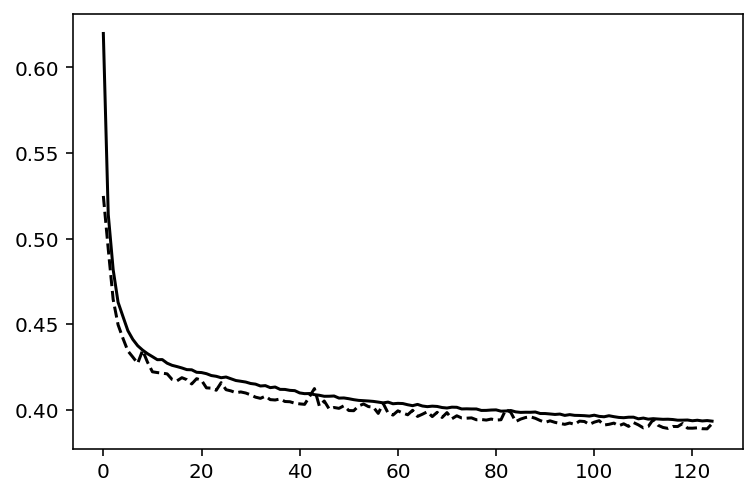

In [26]:
i = max_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'k')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--k')

In [27]:
df[df['dropout'] == True].sort_values(['ml_temperature_test_mean_rmse']).head()

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
51,"[0, 1, 2, 3]","[1, 2]",[],"[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 8)",[],512,"[32, 64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,125,128,False,True,"[0.3027131259441376, 0.27594390511512756, 0.26...","[0.49590831995010376, 0.45052218437194824, 0.4...","[0.24592505395412445, 0.2029702365398407, 0.19...","[0.28687354922294617, 0.26213112473487854, 0.2...","[0.2774202525615692, 0.26604244112968445, 0.26...","[0.45589059591293335, 0.4350384771823883, 0.42...","[0.20783625543117523, 0.18925848603248596, 0.1...","[0.2629685401916504, 0.2527068257331848, 0.249...","[1.096398816387727, 0.9538283839262428, 0.9584...",0.990126,"[1.096398816387727, 0.9538283839262428, 0.9584...",0.999618,"[1.3269080040971217, 1.3830314875182679, 1.468...",4.476157,"[1.3269080040971217, 1.3830314875182679, 1.468...",2.950313,"[1.0817891984083545, 0.9411259450031266, 0.943...",0.990957,"[1.0817891984083545, 0.9411259450031266, 0.943...",0.991890,"[1.4264549113392857, 1.3026712447189916, 1.434...",4.578789,"[1.4264549113392857, 1.3026712447189916, 1.434...",2.919151,"[1.0867832036586877, 0.9161810423833617, 0.912...",0.977970,"[1.0867832036586877, 0.9161810423833617, 0.912...",0.982596,"[1.2224211299951786, 1.319052863772037, 1.4424...",4.565124,"[1.2224211299951786, 1.319052863772037, 1.4424...",2.894930
123,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[32, 64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,125,128,False,True,"[0.2986166477203369, 0.2732030153274536, 0.265...","[0.4881390929222107, 0.4458632469177246, 0.433...","[0.23827975988388062, 0.19879403710365295, 0.1...","[0.28259485960006714, 0.25894466042518616, 0.2...","[0.2734498679637909, 0.2619951069355011, 0.258...","[0.44697636365890503, 0.42413192987442017, 0.4...","[0.19978787004947662, 0.17988790571689606, 0.1...","[0.258627712726593, 0.24816757440567017, 0.244...","[1.105184523155251, 0.9487536660001279, 0.9493...",0.990585,"[1.105184523155251, 0.9487536660001279, 0.9493...",0.997237,"[1.3051484960811603, 1.3541523841968617, 1.448...",4.486370,"[1.3051484960811603, 1.3541523841968617, 1.448...",2.959227,"[1.0900174757105954, 0.9320618842012214, 0.936...",0.991221,"[1.0900174757105954, 0.9320618842012214, 0.936...",0.990875,"[1.4085095272965213, 1.2732168557772476, 1.421...",4.583407,"[1.4085095272965213, 1.2732168557772476, 1.421...",2.925949,"[1.0935596228306959, 0.9104007997961617, 0.904...",0.978564,"[1.0935596228306959, 0.9104007997961617, 0.904...",0.980522,"[1.1995257014047849, 1.3047357860940212, 1.441...",4.578901,"[1.1995257014047849, 1.3047357860940212, 1.441...",2.905075
87,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],"(256, 4)","(3, 3, 3)",[],512,"[32, 64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,125,128,False,True,"[0.31787052750587463, 0.28560182452201843, 0.2...","[0.5171539783477783, 0.4719376862049103, 0.451...","[0.2674482464790344, 0.22272516787052

In [28]:
df.sort_values(['ml_temperature_test_mean_rmse']).head()

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
122,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[32, 64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,125,128,False,False,"[0.2913960814476013, 0.2695964276790619, 0.260...","[0.47909998893737793, 0.4407629668712616, 0.42...","[0.22953678667545319, 0.194271981716156, 0.180...","[0.27529358863830566, 0.2552758455276489, 0.24...","[0.2757836878299713, 0.26426252722740173, 0.25...","[0.4476132392883301, 0.42815515398979187, 0.41...","[0.2003576010465622, 0.18331684172153473, 0.16...","[0.26088231801986694, 0.25037387013435364, 0.2...","[1.1133992160087998, 0.9449474282693618, 0.946...",0.974740,"[1.1133992160087998, 0.9449474282693618, 0.946...",0.986197,"[1.28383330258854, 1.3504258450454922, 1.40113...",4.186786,"[1.28383330258854, 1.3504258450454922, 1.40113...",2.847707,"[1.1007221034344965, 0.9273376200755785, 0.930...",0.981896,"[1.1007221034344965, 0.9273376200755785, 0.930...",0.983889,"[1.3896266757773603, 1.2883615427678492, 1.397...",4.444619,"[1.3896266757773603, 1.2883615427678492, 1.397...",2.848055,"[1.1038549399562605, 0.9075033462426606, 0.900...",0.968594,"[1.1038549399562605, 0.9075033462426606, 0.900...",0.971784,"[1.1782091940352681, 1.2927092068260195, 1.390...",4.433843,"[1.1782091940352681, 1.2927092068260195, 1.390...",2.832742
50,"[0, 1, 2, 3]","[1, 2]",[],"[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 8)",[],512,"[32, 64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,125,128,False,False,"[0.2923714220523834, 0.2679113745689392, 0.260...","[0.4809386134147644, 0.43494367599487305, 0.42...","[0.23130196332931519, 0.18917600810527802, 0.1...","[0.276581734418869, 0.2538857161998749, 0.2469...","[0.2736697196960449, 0.2618383467197418, 0.254...","[0.4428524971008301, 0.42269301414489746, 0.41...","[0.1961183249950409, 0.17866937816143036, 0.16...","[0.2591207027435303, 0.24821369349956512, 0.24...","[1.0808043461461312, 0.9374514241895043, 0.957...",0.977405,"[1.0808043461461312, 0.9374514241895043, 0.957...",0.989833,"[1.2984403980708872, 1.3700233156338613, 1.444...",4.184684,"[1.2984403980708872, 1.3700233156338613, 1.444...",2.910072,"[1.067179953541109, 0.9237640450162792, 0.9414...",0.982311,"[1.067179953541109, 0.9237640450162792, 0.9414...",0.985535,"[1.4025507986338446, 1.3096365436906872, 1.441...",4.474130,"[1.4025507986338446, 1.3096365436906872, 1.441...",2.908328,"[1.074125481373111, 0.8989069337448287, 0.9126...",0.970889,"[1.074125481373111, 0.8989069337448287, 0.9126...",0.974772,"[1.1943263740045447, 1.3168480983903428, 1.431...",4.443108,"[1.1943263740045447, 1.3168480983903428, 1.431...",2.879307
86,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],"(256, 4)","(3, 3, 3)",[],512,"[32, 64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,125,128,False,False,"[0.3001312017440796, 0.27471303939819336, 0.26...","[0.49760666489601135, 0.4536258578300476, 0.43...","[0.24761240184307098, 0.2057764083

# Best Model

In [11]:
from soundings.experiments import cnn_skip_neuralnetwork_driver as cnndriver

from soundings.deep_learning import tf_neuralnetwork as nn

In [12]:
data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)
rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = [0, 1, 2]
goes_input_channels = [0, 1, 2, 3, 4, 5, 6, 7]

driver = cnndriver.CNNSkipNetworkDriver()

Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                                                rtma_input_channels, goes_input_channels)

INFO: data organization - [0, 1, 2, 3] [1, 2] [0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
INFO: data dimensions - (28782, 256, 4) (28782, 3, 3, 11) (28782, 512) (3840, 256, 4) (3840, 3, 3, 11) (3840, 512) (5733, 256, 4) (5733, 3, 3, 11) (5733, 512)


In [13]:
# i = 8
# Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = Xtr[:,::i], Xti, Tt[:,::i], Xvr[:,::i], Xvi, Tv[:,::i], Xer[:,::i], Xei, Te[:,::i]

In [187]:
n_hiddens_list = []
n_units_in_conv_layers = [8, 16, 32, 64, 128]
kernels_size_and_stride = '(3, 1)'
rap_activation = 'elu'
dense_activation = ''
optim = 'adam'
lr = 0.001
loss = 'Huber'
n_epochs = 100
batch_size = 128
dropout = False
batchnorm = False

n_rap_inputs = Xtr.shape[1:] # (256, 4)
n_im_inputs  = Xti.shape[1:] if Xti is not None else None # (3, 3, 3)
n_network_outputs = Tt.shape[1]

nnet = nn.SkipNeuralNetwork(n_rap_inputs, n_im_inputs, n_hiddens_list, n_units_in_conv_layers,
                            [literal_eval(kernels_size_and_stride)]* \
                                len(n_units_in_conv_layers), # all same size
                            n_network_outputs, rap_activation=rap_activation,
                            dense_activation=dense_activation, 
                            batchnorm=batchnorm, dropout=dropout)
nnet.model.summary()
nnet.train(Xtr, Xti, Tt, n_epochs, batch_size, method=optim, verbose=True,
           learning_rate=lr, validation=(Xvr, Xvi, Tv), loss_f=loss)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 8)       104         rap[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 8)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
skip_conv1d_0 (Conv1D)          (None, 256, 8)       200         activation[0][0]                 
_______________________________________________________________________________________

epoch: 0, rmse 0.44530, val_rmse 0.41844
epoch: 20, rmse 0.39809, val_rmse 0.38762
epoch: 40, rmse 0.39445, val_rmse 0.39385
epoch: 60, rmse 0.39239, val_rmse 0.38274
epoch: 80, rmse 0.39248, val_rmse 0.38598
epoch: 99, rmse 0.39126, val_rmse 0.38528
finished!


SkipNeuralNetwork(512)
  Final objective value is 0.07420 in 405.0731 seconds.

## Standard Metrics

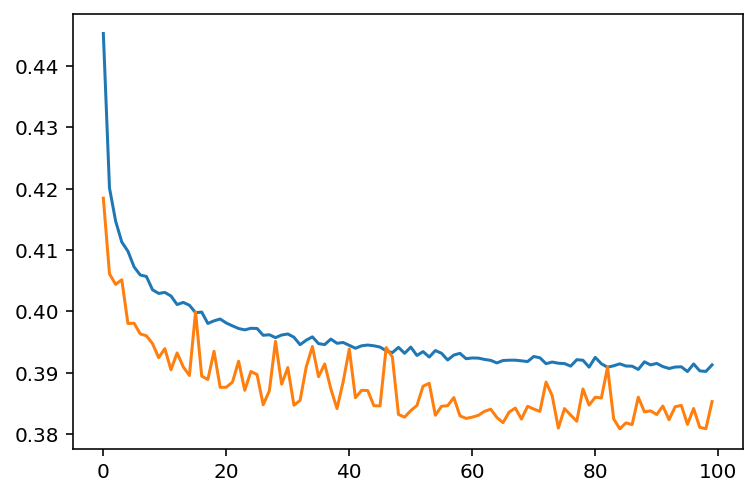

In [188]:
fig, ax = plt.subplots()
ax.plot(nnet.history[f'root_mean_squared_error'])
ax.plot(nnet.history[f'val_root_mean_squared_error'])

In [189]:
r = dict()

TEMP, DEWPT = 0, 1
sets = ['train', 'val', 'test']

for j, (Xr, Xi, RAP, T) in enumerate([(Xtr, Xti, RAPtrain, RAOBtrain),
                                      (Xvr, Xvi, RAPval  , RAOBval),
                                      (Xer, Xei, RAPtest , RAOBtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X).reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,TEMP], T[:, :, 1])
    r[f'ml_temperature_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,DEWPT], T[:, :, 2])
    r[f'ml_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

In [190]:
df = pd.DataFrame([r])

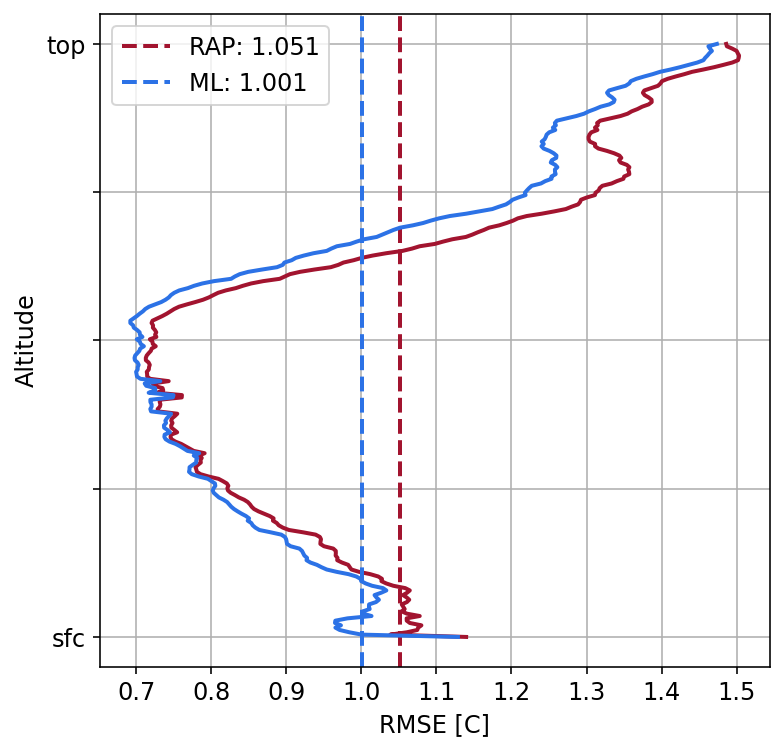

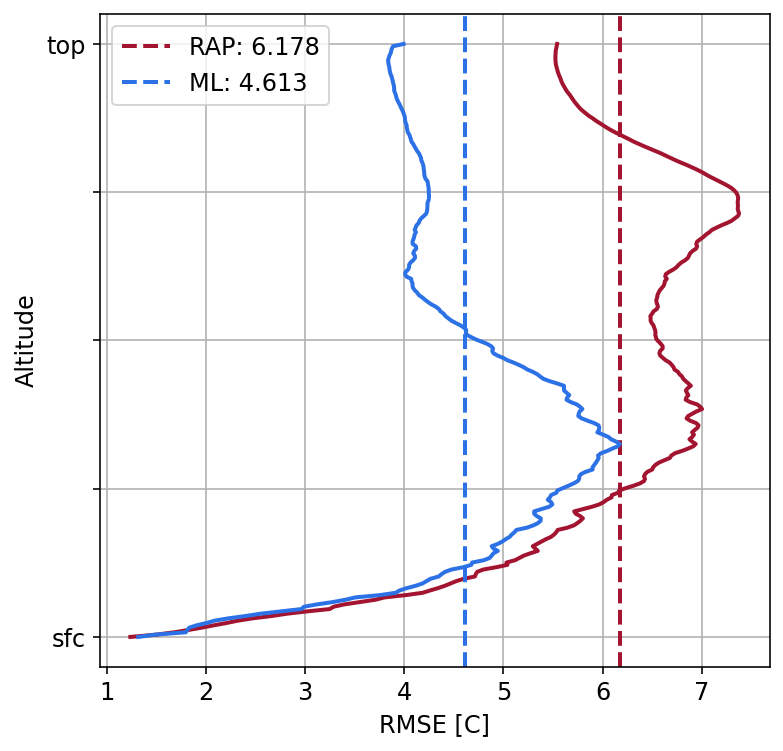

In [191]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(df.iloc[i][f'ml_{v}_{data_set}_rmse'])
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

## Cloud Mask

In [76]:
bcm = np.load('/mnt/data1/stock/mlsoundings/goes_bcm_alley.npy')
bcm[np.isnan(bcm)] = 0 # nans to zero
cloudy = np.zeros(len(bcm))

In [35]:
np.seterr(all='raise')
# 0 = clear or probably clear and 1 = cloudy or probably cloudy.
total = bcm.shape[-2] * bcm.shape[-1]
for i in range(len(bcm)):
    try:
        if (bcm[i] == -1).any(): # invalid
            cloudy[i] = -1
        elif ((bcm[i]>0).sum() / total) > .9: # 50% are cloudy
            cloudy[i] = 1
    except Exception as e:
        print(i,e)

In [36]:
np.unique(cloudy, return_counts=True)

(array([-1.,  0.,  1.]), array([ 2607, 27572,  8194]))

In [37]:
CLOUDtrain, CLOUDval, CLOUDtest = cloudy[train_i], cloudy[val_i], cloudy[test_i]

In [38]:
np.unique(CLOUDtest)

array([-1.,  0.,  1.])

In [39]:
r = dict()

TEMP, DEWPT = 0, 1
sets = ['train', 'val', 'test']

for j, (Xr, Xi, RAP, T, cloud) in enumerate([(Xtr, Xti, RAPtrain, RAOBtrain, CLOUDtrain),
                                             (Xvr, Xvi, RAPval  , RAOBval, CLOUDval),
                                             (Xer, Xei, RAPtest , RAOBtest, CLOUDtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X).reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)
    for c in np.unique(cloud):
        Yc = Y[cloud==c]
        Tc = T[cloud==c]
        Rc = RAP[cloud==c]
        (rmse, mean_rmse, # temperature
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Yc[:,:,TEMP], Tc[:, :, 1])
        r[f'ml_{c}_temperature_{sets[j]}_rmse'] = rmse.tolist()
        r[f'ml_{c}_temperature_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'ml_{c}_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'ml_{c}_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

        (rmse, mean_rmse, # dewpoint
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Yc[:,:,DEWPT], Tc[:, :, 2])
        r[f'ml_{c}_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
        r[f'ml_{c}_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'ml_{c}_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'ml_{c}_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc
        
        (rmse, mean_rmse, # temperature
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Rc[:,:,1], Tc[:, :, 1])
        r[f'rap_{c}_temperature_{sets[j]}_rmse'] = rmse.tolist()
        r[f'rap_{c}_temperature_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'rap_{c}_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'rap_{c}_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

        (rmse, mean_rmse, #dewpoint
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Rc[:,:,2], Tc[:, :, 2])
        r[f'rap_{c}_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
        r[f'rap_{c}_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'rap_{c}_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'rap_{c}_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

In [40]:
df = pd.DataFrame([r])

-1.0
0.0
1.0
-1.0
0.0
1.0


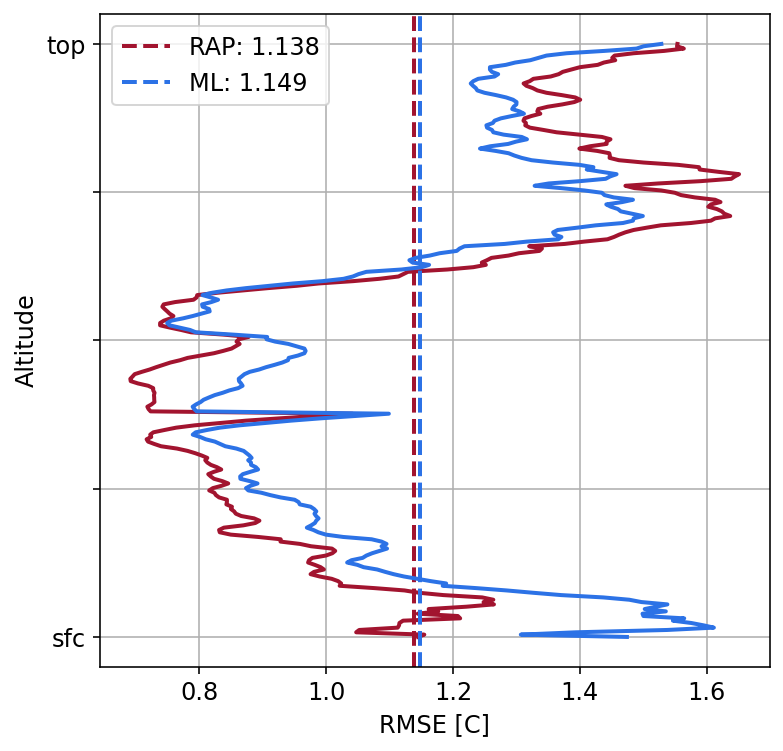

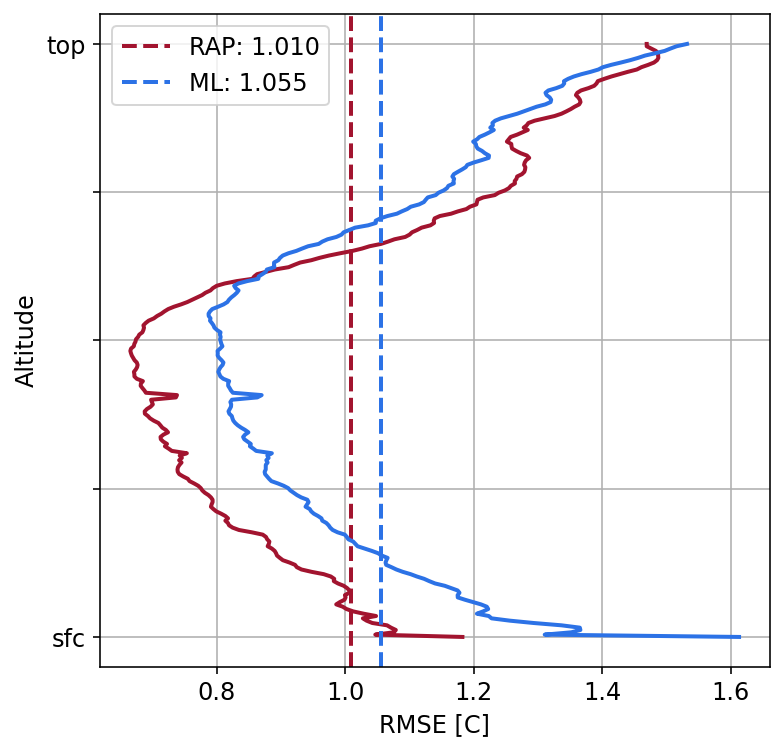

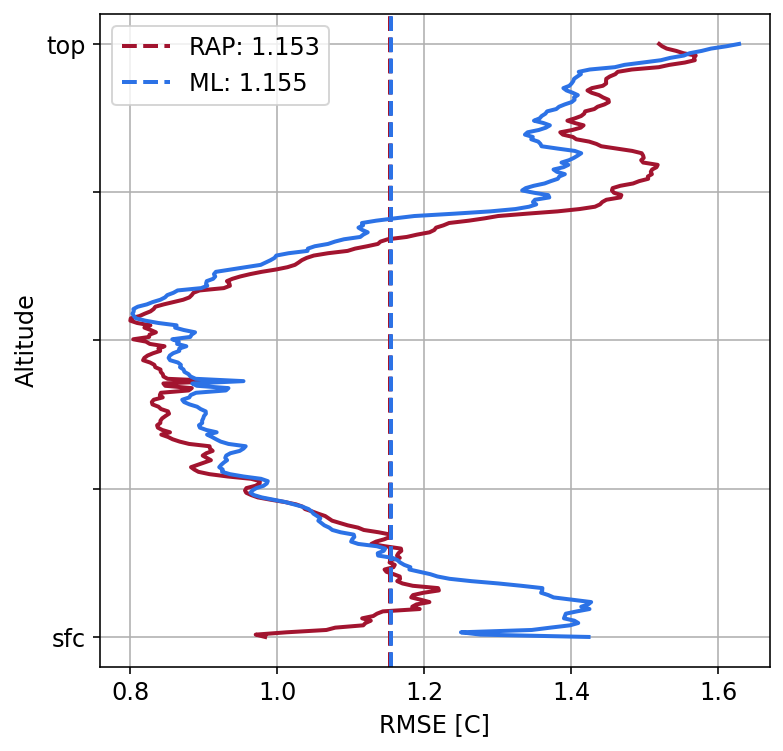

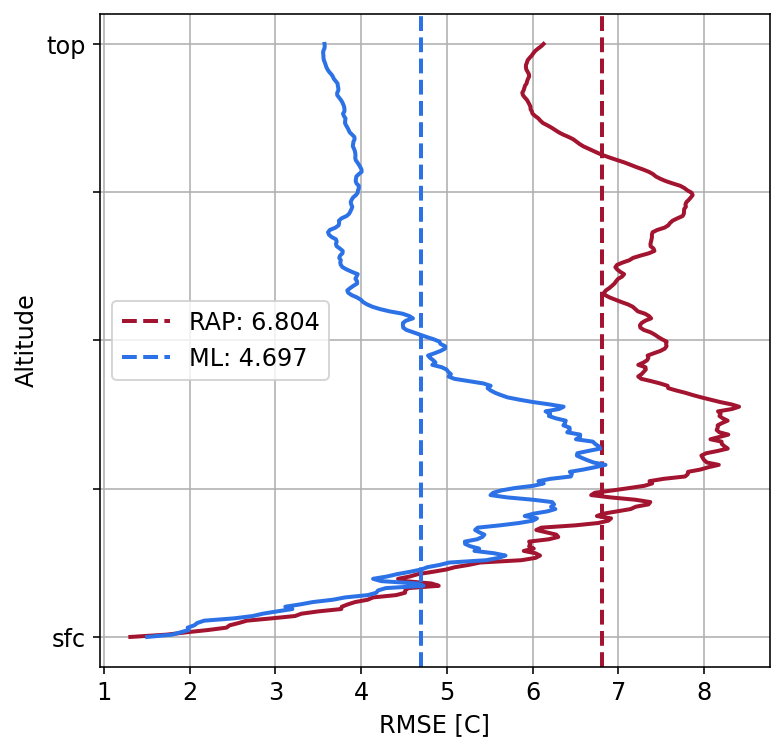

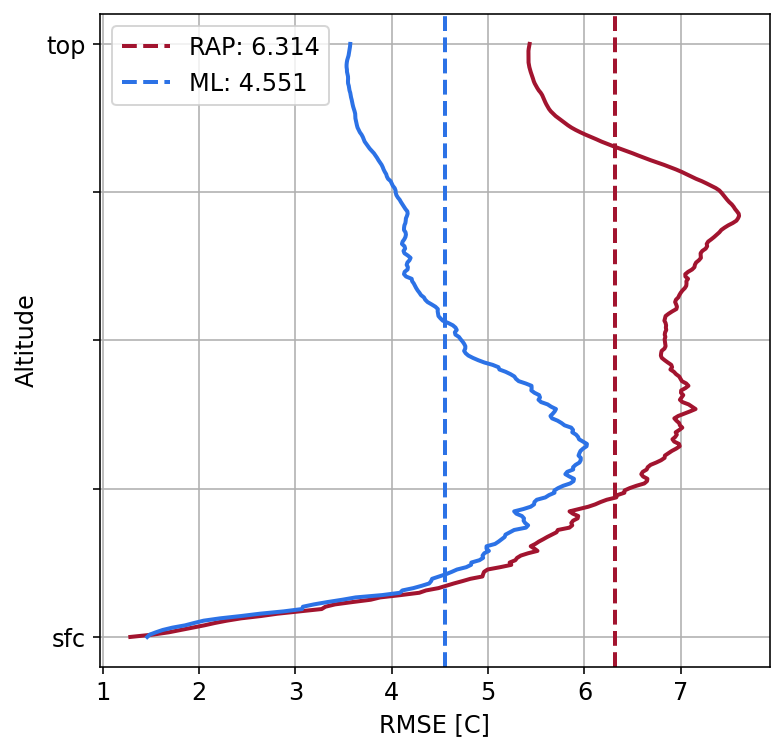

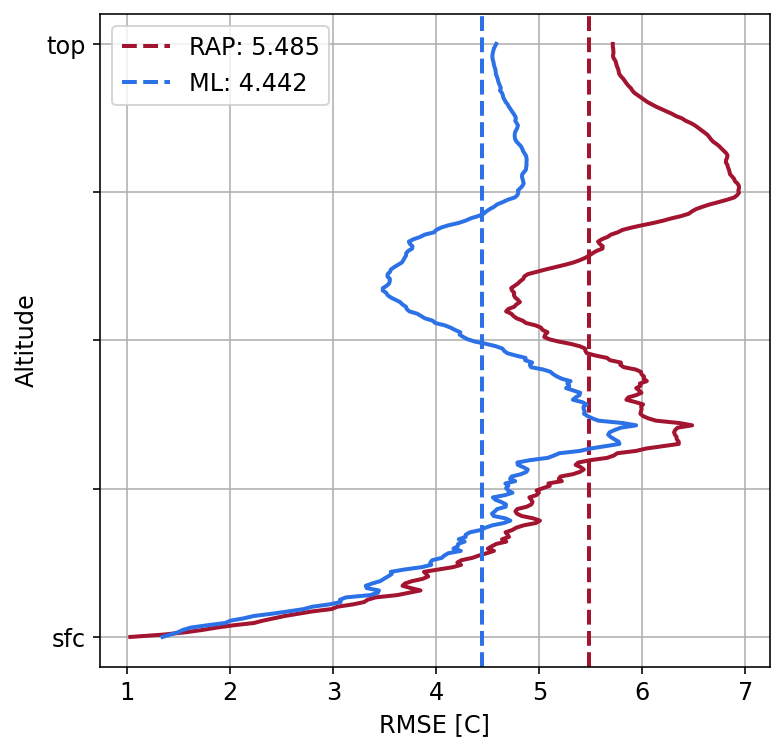

In [41]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    for c in ([-1.0, 0.0, 1.0]):
        print(c)
        ml_rmse = np.asarray(df.iloc[i][f'ml_{c}_{v}_{data_set}_rmse'])
        ml_mean_rmse = df.iloc[i][f'ml_{c}_{v}_{data_set}_mean_rmse']
        rap_rmse = np.asarray(df.iloc[i][f'rap_{c}_{v}_{data_set}_rmse'])
        rap_mean_rmse = df.iloc[i][f'rap_{c}_{v}_{data_set}_mean_rmse']

        results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

## Regional Errors

In [42]:
names_train = [f.split('_')[0] for f in FILEtrain]
names_val   = [f.split('_')[0] for f in FILEval]
names_test  = [f.split('_')[0] for f in FILEtest]

In [50]:
np.unique(np.hstack([names_train, names_val, names_test]), return_counts=True)

(array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
        'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
       dtype='<U3'),
 array([1809, 1754, 1742, 1745, 1219, 1798, 1827, 1824, 1749, 1862, 1696,
        1799, 1746, 1766, 1867, 1855, 1766, 1768]))

In [64]:
locations = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df = pd.DataFrame.from_dict(locations).T
df = df.reset_index()
df.columns = ['location', 'lon', 'lat', 'indicies']
df.head(5)

,location,lon,lat,indicies
0,dvn,-90.57,41.6,"[0, 23, 29, 96, 104, 112, 124, 125, 132, 164, ..."
1,lbf,-100.68,41.13,"[1, 3, 47, 50, 80, 154, 157, 168, 185, 198, 21..."
2,lzk,-92.27,34.83,"[2, 7, 8, 24, 27, 28, 30, 59, 141, 144, 150, 2..."
3,fwd,-97.3,32.8,"[4, 6, 35, 46, 53, 60, 62, 145, 149, 153, 166,..."
4,oun,-97.47,35.23,"[5, 34, 49, 66, 71, 74, 76, 98, 100, 103, 113,..."


In [65]:
t_rmse  = []
td_rmse = []
n_samples = []

X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    T_loc = T[inds]
    Y_loc = Y[inds]
    t_rmse.append(ml.rmse(T_loc[:,:,1], Y_loc[:,:,0]))
    td_rmse.append(ml.rmse(T_loc[:,:,2], Y_loc[:,:,1]))
    n_samples.append(len(inds))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse
df['n_samples'] = n_samples

In [66]:

def regional_error_map(df, count, title, colorscale='ylorbr_r'):
    fig = go.Figure(data=go.Scattergeo(
            locationmode = 'USA-states',
            lon = df['lon'],
            lat = df['lat'],
            text = df['location'],
            mode = 'markers',
            marker = dict(
                size = 6,
                opacity = 0.80,
                reversescale = True,
                autocolorscale = False,
                symbol = 'square',
                line = dict(
                    width=0.80,
                    color='rgba(75, 75, 75)'
                ),
                colorscale = colorscale, # rdgy, viridis
                cmin = df[count].min(), # 0,
                color = df[count],
                cmax = df[count].max(),
                colorbar_title='',
                colorbar = dict(
                    nticks = 10,
                    len = 0.90,
                    thickness = 10,
                    ticks = 'outside',
                    tickcolor = 'black',
                    tickfont = dict(family='Arial', size=11, color='black'), # "Courier New", "Times New Roman"
                    x = 0.90
                ),
            )
                   ))
    """
    ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
     'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
     'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
     'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
     'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
     'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
     'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
     'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
     'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
     'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
     'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
     'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
     'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
     'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
    """
    fig.update_layout(
            geo = dict(
                scope = 'usa',
                projection_type = 'albers usa',
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(100, 100, 100)",
                countrycolor = "rgb(100, 100, 100)",
                countrywidth = 0.5,
                subunitwidth = 0.5
            ), 
            margin=dict(l=0, r=0, t=0, b=5)
        )
    fig.show()

    fig.write_image(title, width=450, height=225, scale=4)

In [59]:
locations = dict()

for i, f in enumerate(np.hstack([FILEtrain,FILEval,FILEtest])):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df_samples = pd.DataFrame.from_dict(locations).T
df_samples = df_samples.reset_index()
df_samples.columns = ['location', 'lon', 'lat', 'indicies']

n_samples = []

for i in range(len(df_samples)):
    inds = df_samples.iloc[i]['indicies']
    n_samples.append(len(inds))

df_samples['n_samples'] = n_samples

In [ ]:
"""
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
 'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
 'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
 'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
 'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
 'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
 'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
"""

In [75]:
regional_error_map(df_samples, 'n_samples', '/home/stock/research/media/n_samples_map.png', colorscale='blues')

In [67]:
regional_error_map(df, 't_rmse', '/home/stock/research/media/temperature_error_bubble_map.png')

In [68]:
regional_error_map(df, 'td_rmse', '/home/stock/research/media/dewpoint_error_bubble_map.png')

## Error Distribution by Month

In [69]:
from soundings.plotting import radiosonde_plotting

In [70]:
samples = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    month = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    if month in samples:
        arr = samples[month][0]
        arr.append(i)
        samples[month] = [arr]
    else:
        samples[month] = [[i]]
        
df = pd.DataFrame.from_dict(samples).T
df = df.reset_index()
df.columns = ['month', 'indicies']

df = df.sort_values('month')
df.head(5)

,month,indicies
3,1,"[4, 12, 54, 62, 85, 97, 112, 117, 128, 149, 15..."
4,2,"[5, 17, 19, 32, 49, 69, 74, 103, 138, 146, 155..."
6,3,"[7, 9, 14, 21, 38, 40, 46, 50, 99, 106, 118, 1..."
0,4,"[0, 2, 26, 31, 58, 72, 88, 90, 92, 100, 108, 1..."
11,5,"[33, 39, 43, 73, 80, 83, 89, 121, 127, 129, 13..."


In [71]:
t_rmse  = []
td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    # sqrt of the mean difference between each vertical level (256,)
    t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - Y[inds,:,0])**2, axis=0)))
    td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - Y[inds,:,1])**2, axis=0)))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse

In [72]:
df.head()

,month,indicies,t_rmse,td_rmse
3,1,"[4, 12, 54, 62, 85, 97, 112, 117, 128, 149, 15...","[1.2059210820086346, 1.0225752248399411, 1.086...","[1.2426023267407609, 1.3669762682986002, 1.534..."
4,2,"[5, 17, 19, 32, 49, 69, 74, 103, 138, 146, 155...","[1.1300259844234737, 1.1528182760892969, 1.170...","[1.2069913796168394, 1.421190277925964, 1.5383..."
6,3,"[7, 9, 14, 21, 38, 40, 46, 50, 99, 106, 118, 1...","[1.1654063241660162, 0.962102425219596, 0.9332...","[1.3745991343947497, 1.4330532872324377, 1.624..."
0,4,"[0, 2, 26, 31, 58, 72, 88, 90, 92, 100, 108, 1...","[0.9698447380795817, 0.8845628303232936, 0.876...","[1.2878952252755478, 1.3487266640994702, 1.415..."
11,5,"[33, 39, 43, 73, 80, 83, 89, 121, 127, 129, 13...","[1.1253089828718927, 0.976641901498326, 0.9655...","[1.2785299853140655, 1.34811258226194, 1.43539..."


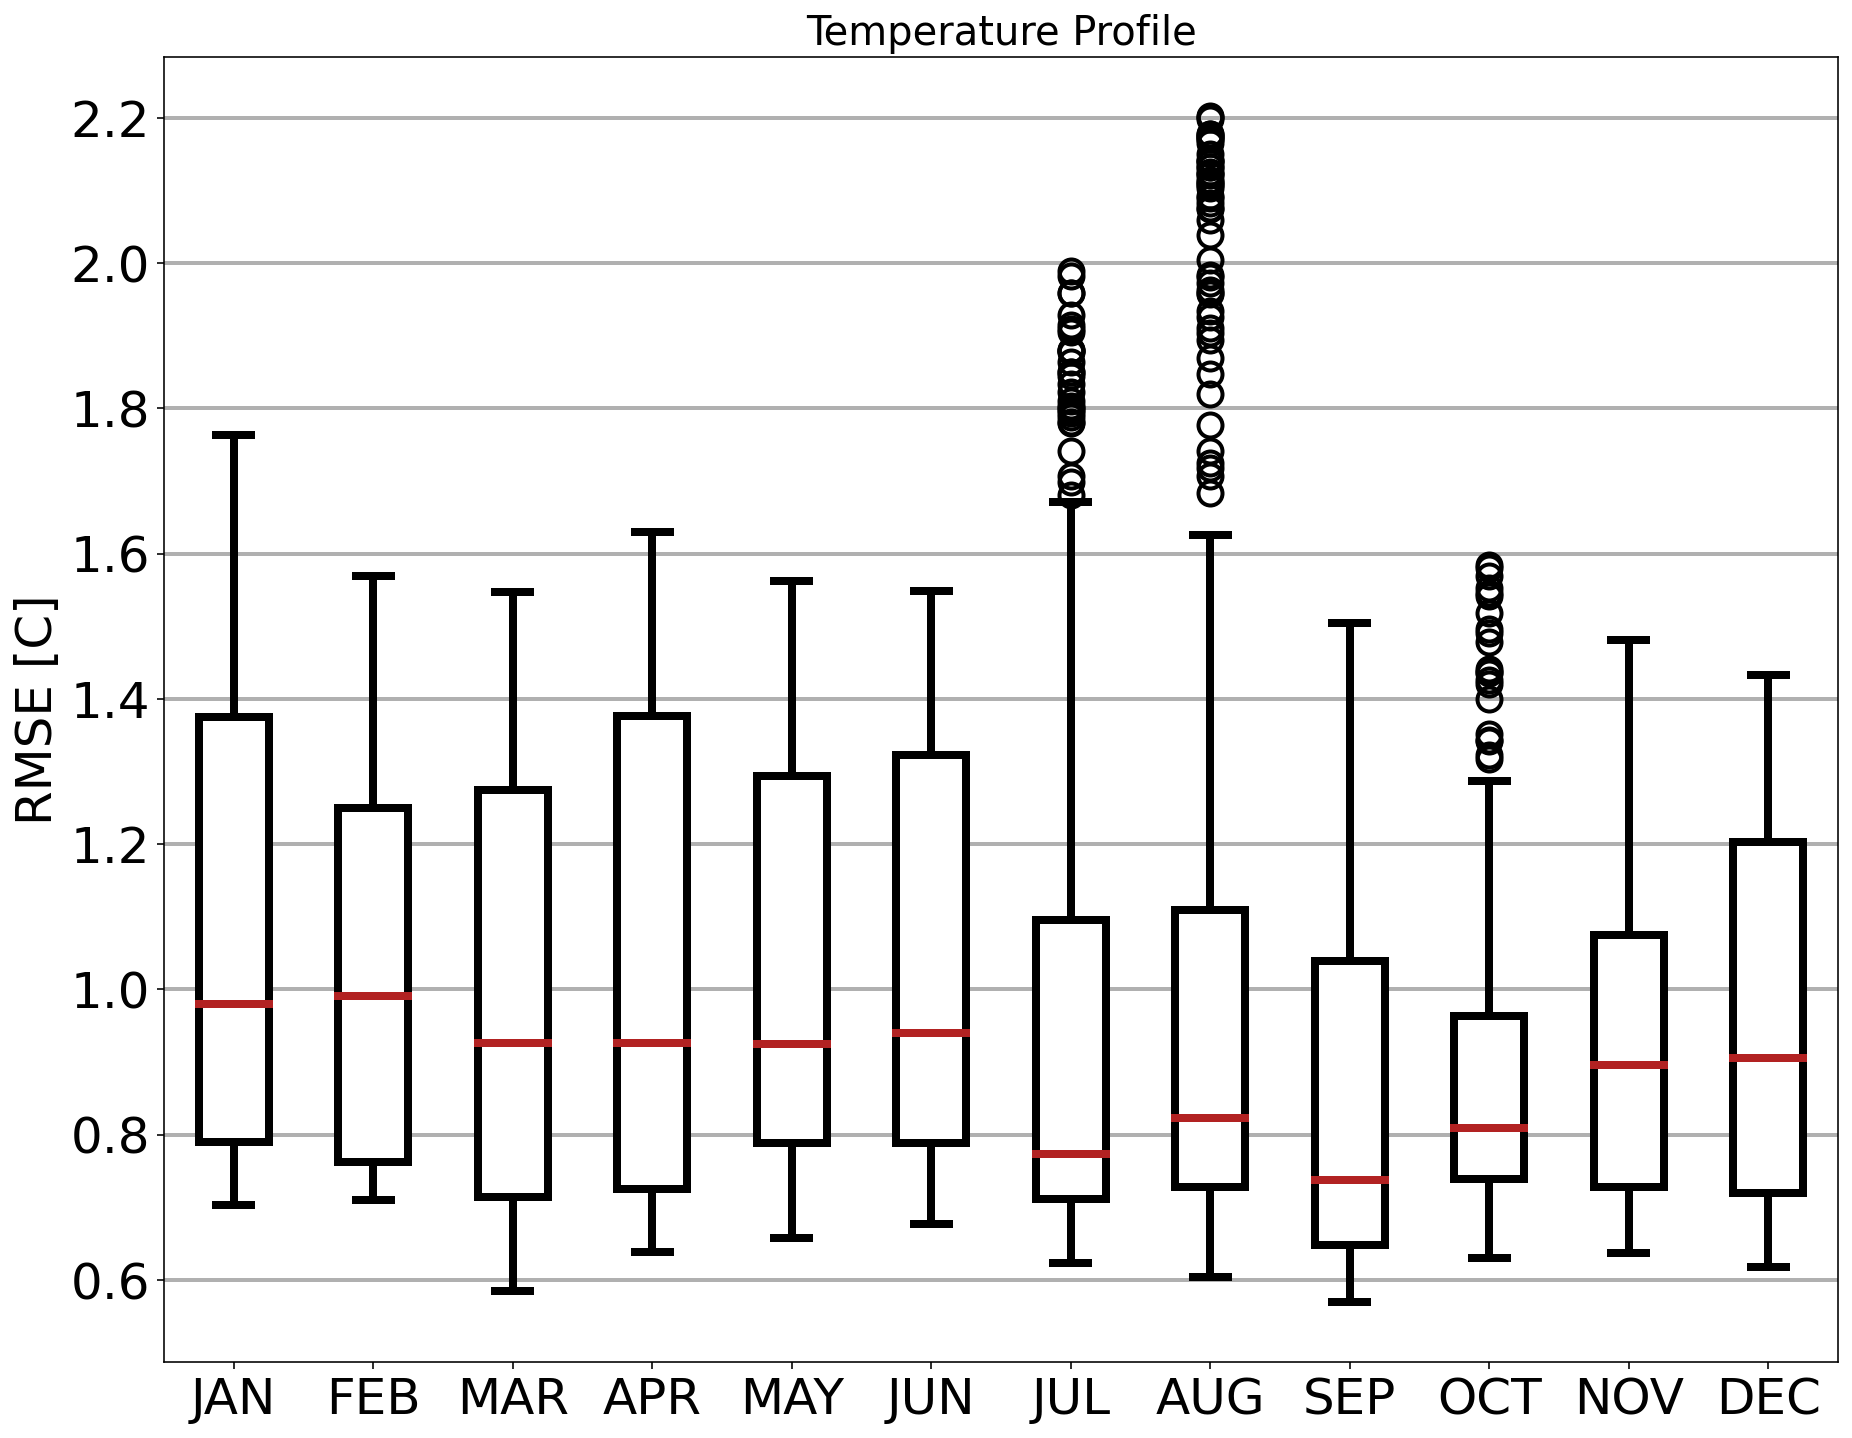

In [73]:
radiosonde_plotting.plot_monthly_error(df['t_rmse'].values, df['month'].values, 'Temperature Profile', 
                                       file_name='/home/stock/research/media/temperature_monthly_error.png');

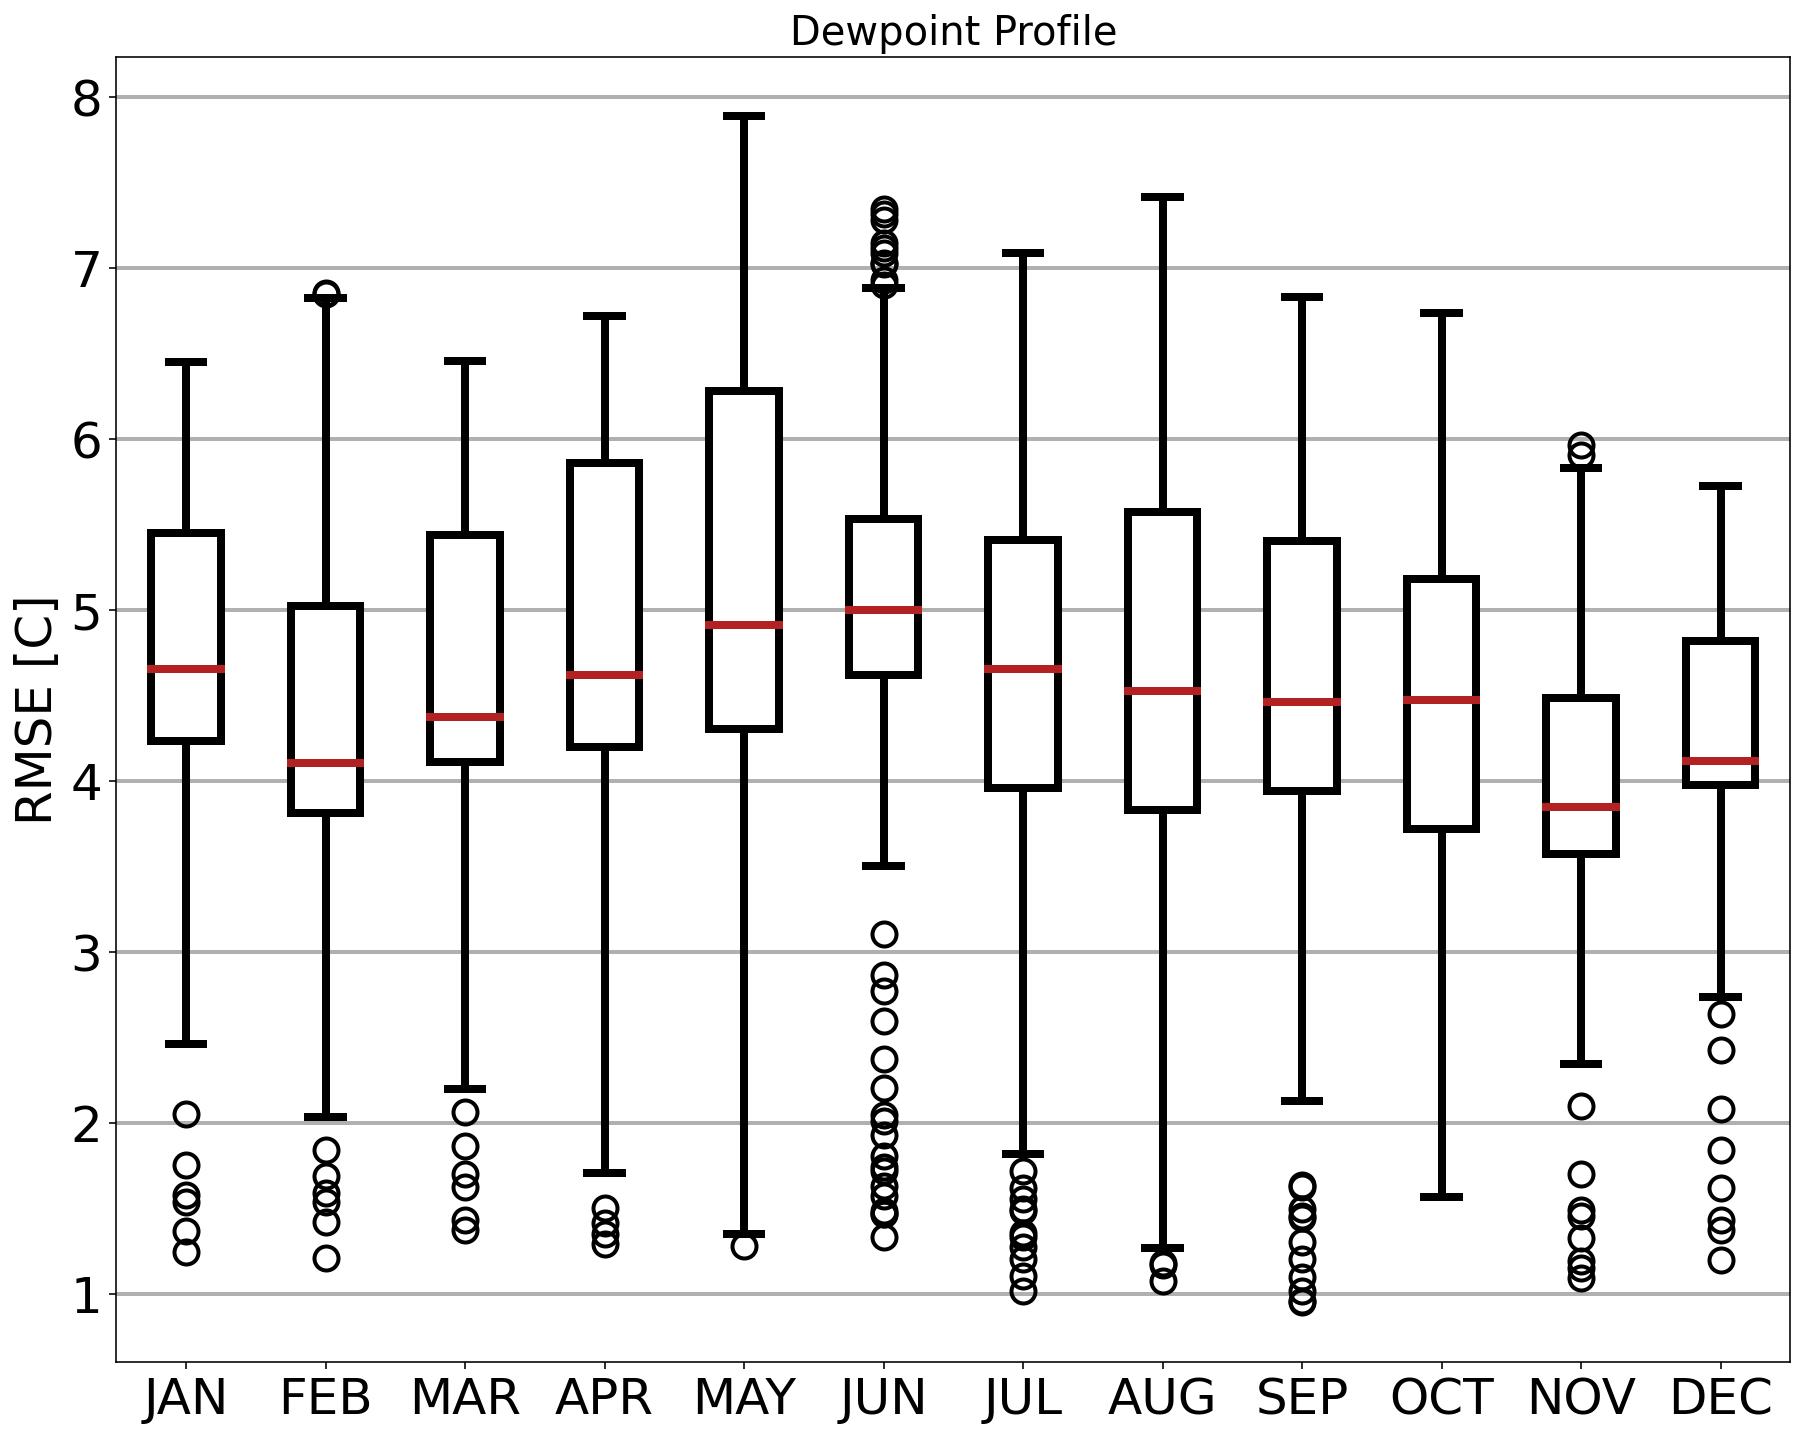

In [74]:
radiosonde_plotting.plot_monthly_error(df['td_rmse'].values, df['month'].values, 'Dewpoint Profile',
                                       file_name='/home/stock/research/media/dewpoint_monthly_error.png');